<a href="https://colab.research.google.com/github/annhater/isdd_projects/blob/main/ai_2/plant_disease_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Retrieve the data in three distinct variables: train ds, val ds, test ds.
- imported another library (os) to load data frome google drive

In [14]:
#library import
import random, numpy as np, tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#set seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#retrieve photos to analyse
DATA_DIR = "/content/drive/MyDrive/UNIVERSITY/M1/Apprentissage profond et Intelligence artificielle 2 "
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "validation")
TEST_DIR  = os.path.join(DATA_DIR, "test")

#set standartization parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 3
AUTOTUNE = tf.data.AUTOTUNE

Mounted at /content/drive


In [15]:
# Retrieve the data
# will load data in RGB by default
train_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
)

val_ds = keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
)

test_ds = keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
)

class_names = train_ds.class_names
class_names

Found 630 files belonging to 3 classes.
Found 60 files belonging to 3 classes.
Found 150 files belonging to 3 classes.


['Healthy', 'Powdery', 'Rust']

2. Display a sample of 9 images.
- We must first do a preprocessing: transform the image into a vector

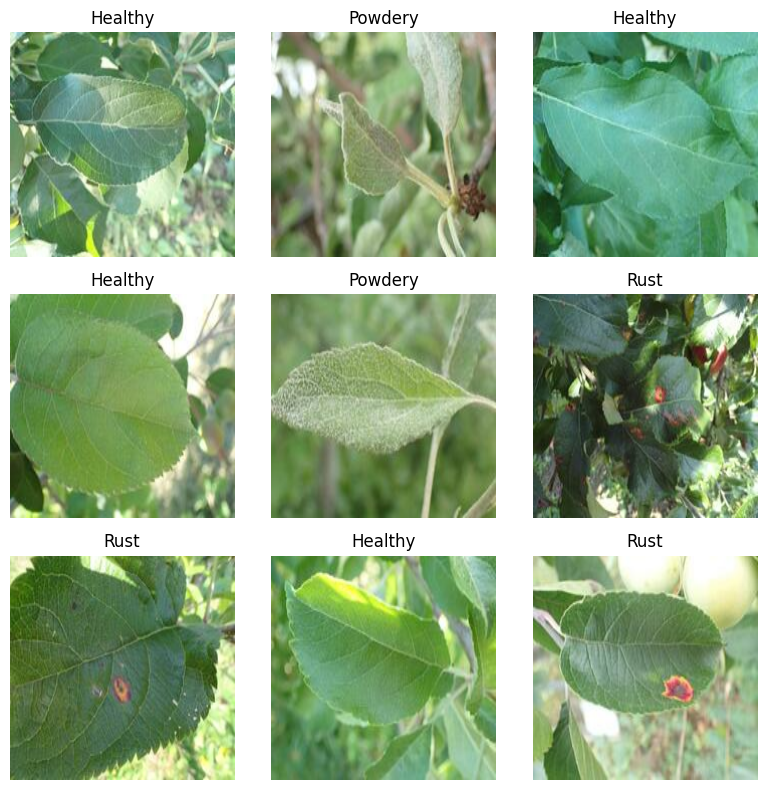

In [16]:
# Visualisation d'un sample -- QUESTION 2 : ECRIVEZ UNE FONCTION AFIN D'AFFICHER UN SAMPLE DE 9 IMAGES DE NOTRE DATASET
def show_batch(dataset, class_names, max_images=9):
    images, labels = next(iter(dataset))
    plt.figure(figsize=(8, 8))
    for i in range(min(max_images, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        img_to_display = images[i].numpy()
        img_to_display = img_to_display / 255.0
        # we scale 0-255 to a smaller range and normalizes image data to [0, 1]
        #allows for a faster optimization and stability
        plt.imshow(img_to_display)
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
    plt.tight_layout()

show_batch(train_ds, class_names)

3. Build a first dense network with 2 hidden layers.

In [17]:
# construction du MLP
def build_mlp(input_shape, num_classes):
    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Flatten()(x)
    #1
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    #2
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="mlp_baseline")
    return model

mlp = build_mlp(IMG_SIZE, NUM_CLASSES)
mlp.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
mlp.summary()


Model: "mlp_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,202,947 (294.51 MB)

 Trainable params: 77,202,947 (294.51 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# training MLP
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=4, restore_best_weights=True
)

history_mlp = mlp.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,
    #callbacks=[early_stop],
    verbose=2
)

Epoch 1/6
20/20 - 40s - 2s/step - accuracy: 0.3524 - loss: 68.7648 - val_accuracy: 0.3333 - val_loss: 48.7892
Epoch 2/6
20/20 - 35s - 2s/step - accuracy: 0.3937 - loss: 16.9929 - val_accuracy: 0.4667 - val_loss: 3.0516
Epoch 3/6
20/20 - 45s - 2s/step - accuracy: 0.4667 - loss: 2.9630 - val_accuracy: 0.4833 - val_loss: 1.0020
Epoch 4/6
20/20 - 35s - 2s/step - accuracy: 0.5333 - loss: 1.0307 - val_accuracy: 0.4833 - val_loss: 0.9300
Epoch 5/6
20/20 - 36s - 2s/step - accuracy: 0.6032 - loss: 0.8770 - val_accuracy: 0.6000 - val_loss: 0.9649
Epoch 6/6
20/20 - 42s - 2s/step - accuracy: 0.5778 - loss: 0.9555 - val_accuracy: 0.5667 - val_loss: 0.9604


5. Display the learning curves. Comment.

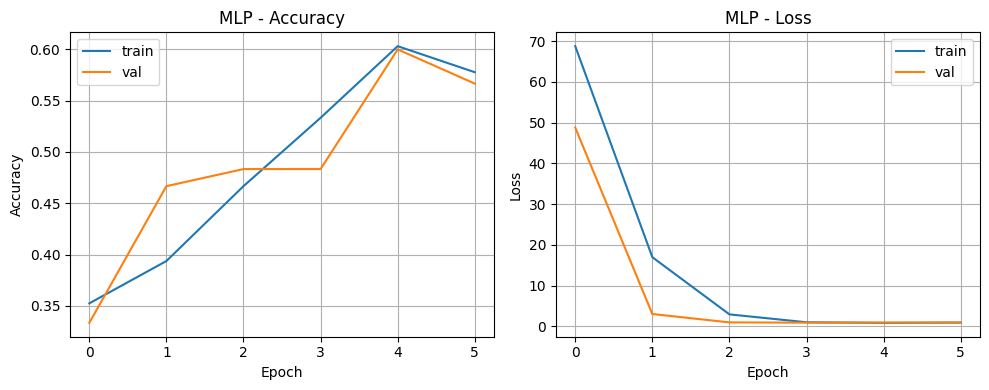

In [19]:
# learning curves
def plot_history(history, title="Training history"):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_history(history_mlp, "MLP")

- We observe a rather rapid decrease of loss (from 50% to 14% after one epoch), wich indicates that the adaptive learning rate optimizer (Adam, stochastic gradient descent) works well, and allows to compute new updated and optimized parameters for the image analysis.

- We also note that the Accuracy for validation set and train set increases with each iteration. Test on valid is not stagnant, so there is no over-fitting. With model training with over 6 epochs, however we see a quick drop of accuracy for both models, that indicates the limits of learning in this model. An accuracy around 60% is often the "ceiling" for a simple MLP on complex images. So, this result is well expected.

6. Display the confusion matrix.

Confusion matrix (MLP):
 [[21 12 17]
 [ 5 43  2]
 [20 16 14]]

Classification report (MLP):
               precision    recall  f1-score   support

     Healthy     0.4565    0.4200    0.4375        50
     Powdery     0.6056    0.8600    0.7107        50
        Rust     0.4242    0.2800    0.3373        50

    accuracy                         0.5200       150
   macro avg     0.4955    0.5200    0.4952       150
weighted avg     0.4955    0.5200    0.4952       150



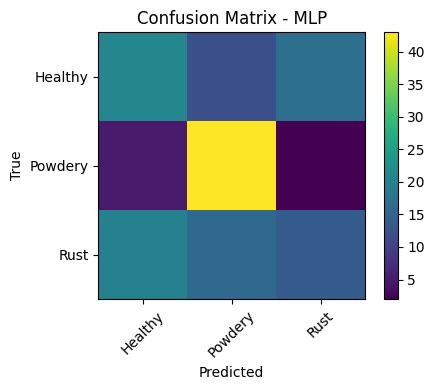

In [21]:
# evaluation du MLP
def predict_dataset(model, dataset):
    y_true = []
    y_pred = []
    for batch_images, batch_labels in dataset:
        preds = model.predict(batch_images, verbose=0)
        y_true.extend(batch_labels.numpy().tolist())
        y_pred.extend(np.argmax(preds, axis=1).tolist())
    return np.array(y_true), np.array(y_pred)

y_true_mlp, y_pred_mlp = predict_dataset(mlp, test_ds)

cm_mlp = confusion_matrix(y_true_mlp, y_pred_mlp)
print("Confusion matrix (MLP):\n", cm_mlp)
print("\nClassification report (MLP):\n",
      classification_report(y_true_mlp, y_pred_mlp, target_names=class_names, digits=4))

plt.figure(figsize=(5,4))
plt.imshow(cm_mlp, interpolation="nearest")
plt.title("Confusion Matrix - MLP")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

- We observe that the model is excellent at identifying Powdery images (43 out of 50 correct). This is most likely to how MLP flattens an image. I can detects that the overall colour of the leaf is brighter/more white pixels, and associates it with Powdery.
- At the same time we see that the model confuses Healthy and Rusty leaves, most likely because the rust doesn't cover the full leaf, but inly part of it, leaving the major part of the leaf still green. This means our model can only see the overall color of the leaf and not specific spots.

- In order to improve the models prediction for healthy and rusty leaves we could use a different model like CNN, that will analyse image as a whole, without flattening it, and seeing the specific spots/shapes of the rust using 2d relationship, which MLP cannot do.

7. Build a convolution model with 4 carbon layers that will include 32 filters.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
model = Sequential()
model.add(Conv2D(16, (3, 3), padding = "same", activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), padding = "same", activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 1)))
#16 filtres, taille de filtre = (3,3) => n de param = 16 * 9 => 16 image produits
#reduit la taille d'image par 2 => 26/2 = 13*13
model.add(MaxPooling2D((2, 2)))
#pooling de 2*2 pour reduire la taille d'image par 4
model.add(Flatten())#mettre à plat, un seul vecteur
model.add(Dense(32, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.summary()

8. Launch the training and save the history

In [ ]:
# training MLP
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=4, restore_best_weights=True
)

history_mlp = mlp.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,
    #callbacks=[early_stop],
    verbose=2
)

9. Show learning curves. Comment.

In [ ]:
# learning curves
def plot_history(history, title="Training history"):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_history(history_mlp, "MLP")

10. Display the confusion matrix.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
model = Sequential()
model.add(Conv2D(16, (3, 3), padding = "same", activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), padding = "same", activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 1)))
#16 filtres, taille de filtre = (3,3) => n de param = 16 * 9 => 16 image produits
#reduit la taille d'image par 2 => 26/2 = 13*13
model.add(MaxPooling2D((2, 2)))
#pooling de 2*2 pour reduire la taille d'image par 4
model.add(Flatten())#mettre à plat, un seul vecteur
model.add(Dense(32, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.summary()

11. Compare the results of the two models. Comment.